In [2]:
import os
import sys
import numpy as np
import h5py
import scipy.io as spio
import nibabel as nib

import argparse

In [3]:
if 'ipykernel' in sys.modules:  # Checks if script is running in Jupyter Notebook
    # Default values for Jupyter Notebook
    sub = 1  # Set desired default value
    batch_size = 30  # Default batch size
else:
    parser = argparse.ArgumentParser(description='Argument Parser')
    parser.add_argument("-sub", "--sub", help="Subject Number", default=7)
    parser.add_argument("-bs", "--bs", help="Batch Size", default=30)
    args = parser.parse_args()
    sub = int(args.sub)
    assert sub in [1, 2, 5, 7]
    batch_size = int(args.bs)

print('Libs imported')
print(f'Using Subject Number: {sub}')
print(f'Using Batch Size: {batch_size}')

Libs imported
Using Subject Number: 1
Using Batch Size: 30


In [4]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)



In [5]:
from scipy.io.matlab import mat_struct

In [6]:
stim_order_f = 'C:/Users/sOrOush/SoroushProjects/01_Soroush_and_Shakiba/NSD_High_Dimensional_Data/11_Marco_And_Soroush/Data/nsddata/experiments/nsd/nsd_expdesign.mat'
stim_order = loadmat(stim_order_f)

C:\Users\sOrOush\AppData\Local\Temp\ipykernel_7568\1180514422.py:14: DeprecationWarning: Please import `mat_struct` from the `scipy.io.matlab` namespace; the `scipy.io.matlab.mio5_params` namespace is deprecated and will be removed in SciPy 2.0.0.
  if isinstance(d[key], spio.matlab.mio5_params.mat_struct):


In [7]:
stim_order.keys()

dict_keys(['__header__', '__version__', '__globals__', 'basiccnt', 'masterordering', 'sharedix', 'stimpattern', 'subjectim'])

In [8]:
stim_order['subjectim'].shape

(8, 10000)

In [9]:
## Selecting ids for training and test data

sig_train = {}
sig_test = {}
num_trials = 37*750
for idx in range(num_trials):
    ''' nsdId as in design csv files'''
    nsdId = stim_order['subjectim'][sub-1, stim_order['masterordering'][idx] - 1] - 1
    if stim_order['masterordering'][idx]>1000:
        if nsdId not in sig_train:
            sig_train[nsdId] = []
        sig_train[nsdId].append(idx)
    else:
        if nsdId not in sig_test:
            sig_test[nsdId] = []
        sig_test[nsdId].append(idx)


train_im_idx = list(sig_train.keys())
test_im_idx = list(sig_test.keys())

In [10]:
roi_dir = 'C:/Users/sOrOush/SoroushProjects/01_Soroush_and_Shakiba/NSD_High_Dimensional_Data/11_Marco_And_Soroush/Data/nsddata/ppdata/subj{:02d}/func1pt8mm/roi/'.format(sub)
betas_dir = 'C:/Users/sOrOush/SoroushProjects/01_Soroush_and_Shakiba/NSD_High_Dimensional_Data/11_Marco_And_Soroush/Data/nsddata_betas/ppdata/subj{:02d}/func1pt8mm/betas_fithrf_GLMdenoise_RR/'.format(sub)

mask_filename = 'HCP_MMP1.nii.gz'
mask = nib.load(roi_dir+mask_filename).get_fdata()


In [11]:
roi_dir_test = 'C:/Users/sOrOush/SoroushProjects/01_Soroush_and_Shakiba/NSD_High_Dimensional_Data/11_Marco_And_Soroush/Data/nsddata/ppdata/subj{:02d}/func1pt8mm/roi/'.format(sub)
betas_dir_test = 'C:/Users/sOrOush/SoroushProjects/01_Soroush_and_Shakiba/NSD_High_Dimensional_Data/11_Marco_And_Soroush/Data/nsddata_betas/ppdata/subj{:02d}/func1pt8mm/betas_fithrf_GLMdenoise_RR/'.format(sub)

mask_filename_test = 'nsdgeneral.nii.gz'
mask_test = nib.load(roi_dir+mask_filename_test).get_fdata()

In [12]:
mask.shape # subj 01

(81, 104, 83)

In [13]:
mask_test.shape # subj 02

(81, 104, 83)

In [14]:
type(mask)

numpy.ndarray

In [15]:
mask_nii = nib.load(roi_dir + mask_filename)

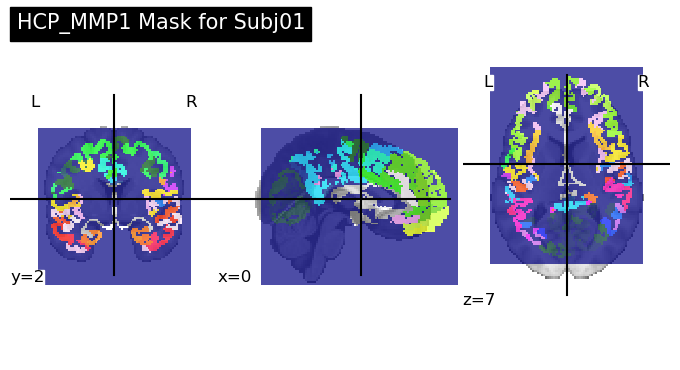

In [16]:
import nibabel as nib
from nilearn.plotting import plot_roi, show
# Plot the mask
plot_roi(mask_nii, title="HCP_MMP1 Mask for Subj01")
show()

In [18]:
mask_nii_test = nib.load(roi_dir_test + mask_filename_test)

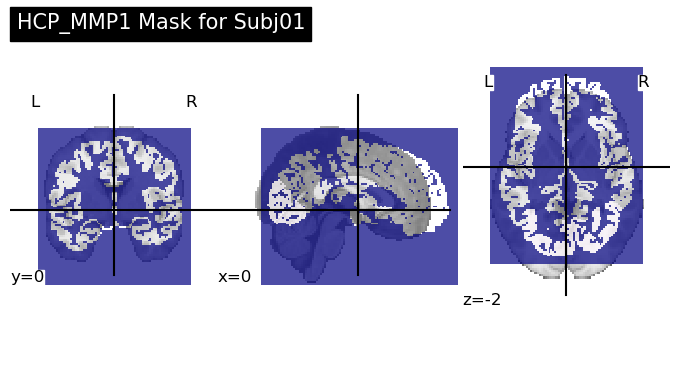

In [19]:
import nibabel as nib
from nilearn.plotting import plot_roi, show
# Plot the mask
plot_roi(mask_nii_test, title="HCP_MMP1 Mask for Subj01")
show()

In [20]:
mask_nii

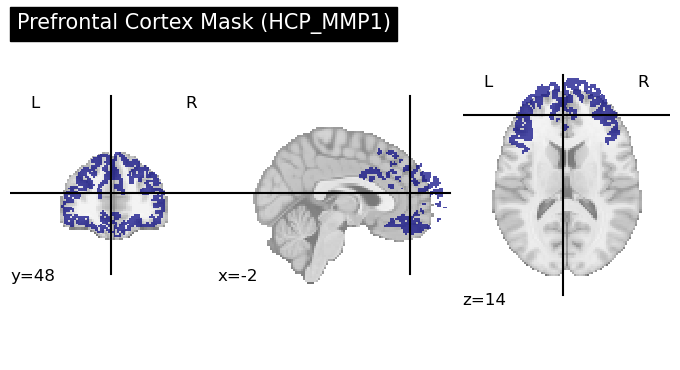

In [21]:
import numpy as np
import nibabel as nib
from nilearn.plotting import plot_roi, show
#
# # Load the mask
# mask_nii = nib.load(roi_dir + mask_filename)
mask_data = mask_nii.get_fdata()

# Suppose you have a list of region indices corresponding to Prefrontal Cortex
pfc_region_ids = [
    26, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
    71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86,
    87, 88, 89, 90, 91, 92, 93, 94, 97, 98, 164, 165, 166, 170,
    171, 179
]

  # <<< example only, depends on your label file

# Create a binary mask selecting only the prefrontal areas
pfc_mask = np.isin(mask_data, pfc_region_ids)

# Turn the binary mask into an image
pfc_mask_img = nib.Nifti1Image(pfc_mask.astype(np.int8), affine=mask_nii.affine)

# Plot
plot_roi(pfc_mask_img, title="Prefrontal Cortex Mask (HCP_MMP1)")
show()


In [22]:
np.prod(pfc_mask.shape)

699192

In [23]:
true_count = np.sum(pfc_mask)
total_voxels = np.prod(pfc_mask.shape)
percentage = (true_count / total_voxels) * 100

print(f"Number of voxels in PFC mask: {true_count}")
print(f"Percentage of brain covered: {percentage:.2f}%")


Number of voxels in PFC mask: 26296
Percentage of brain covered: 3.76%


In [24]:
print(np.min(mask_data), np.max(mask_data))


-1.0 180.0


In [25]:
print(np.min(mask_test), np.max(mask_test))

-1.0 1.0


In [27]:
mask_test

array([[[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]],

       [[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]],

       [[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]],

       ...,

       [[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.

In [26]:
print(np.min(pfc_mask), np.max(pfc_mask))

False True


In [28]:
# Get unique values and their counts
values, counts = np.unique(mask_test, return_counts=True)

# Show results
for val, count in zip(values, counts):
    print(f"Value {val} occurs {count} times")

Value -1.0 occurs 592088 times
Value 0.0 occurs 91380 times
Value 1.0 occurs 15724 times


In [30]:
mask_test[mask_test>0].shape[0]

15724

In [29]:
# Get unique values and their counts
values, counts = np.unique(pfc_mask, return_counts=True)

# Show results
for val, count in zip(values, counts):
    print(f"Value {val} occurs {count} times")

Value False occurs 672896 times
Value True occurs 26296 times


In [31]:
pfc_mask_int = pfc_mask.astype(np.uint8)


In [32]:
values, counts = np.unique(pfc_mask_int, return_counts=True)
for val, count in zip(values, counts):
    print(f"Value {val} occurs {count} times")


Value 0 occurs 672896 times
Value 1 occurs 26296 times


In [33]:
pfc_mask_int.shape #pfc_mask

(81, 104, 83)

In [34]:
num_voxel = pfc_mask_int[pfc_mask_int>0].shape[0]

fmri = np.zeros((num_trials, num_voxel)).astype(np.float32)
for i in range(37):
    beta_filename = "betas_session{0:02d}.nii.gz".format(i+1)
    beta_f = nib.load(betas_dir+beta_filename).get_fdata().astype(np.float32)
    fmri[i*750:(i+1)*750] = beta_f[mask>0].transpose()
    del beta_f
    print(i)

print("fMRI Data are loaded.")

FileNotFoundError: No such file or no access: 'C:/Users/sOrOush/SoroushProjects/01_Soroush_and_Shakiba/NSD_High_Dimensional_Data/11_Marco_And_Soroush/Data/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session01.nii.gz'